In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [134]:
df = pd.read_parquet('../data/cleaned/sp500.parquet')
df

,Date,Close,High,Low,Open,Volume,LogRet
0,2005-09-19,1231.020020,1237.910034,1227.650024,1237.910034,2076540000,NaN
1,2005-09-20,1221.339966,1236.489990,1220.069946,1231.020020,2319250000,-0.007895
2,2005-09-21,1210.199951,1221.520020,1209.890015,1221.339966,2548150000,-0.009163
3,2005-09-22,1214.619995,1216.640015,1205.349976,1210.199951,2424720000,0.003646
4,2005-09-23,1215.290039,1218.829956,1209.800049,1214.619995,1973020000,0.000551
...,...,...,...,...,...,...,...
5026,2025-09-11,6587.470215,6592.890137,6545.799805,6554.410156,5426460000,0.008450
5027,2025-09-12,6584.290039,6600.209961,6579.490234,6590.660156,4641640000,-0.000483
5028,2025-09-15,6615.279785,6619.620117,6602.069824,6603.490234,5045020000,0.004696
5029,2025-09-16,6606.759766,6626.990234,6600.109863,6624.129883,5359510000,-0.001289


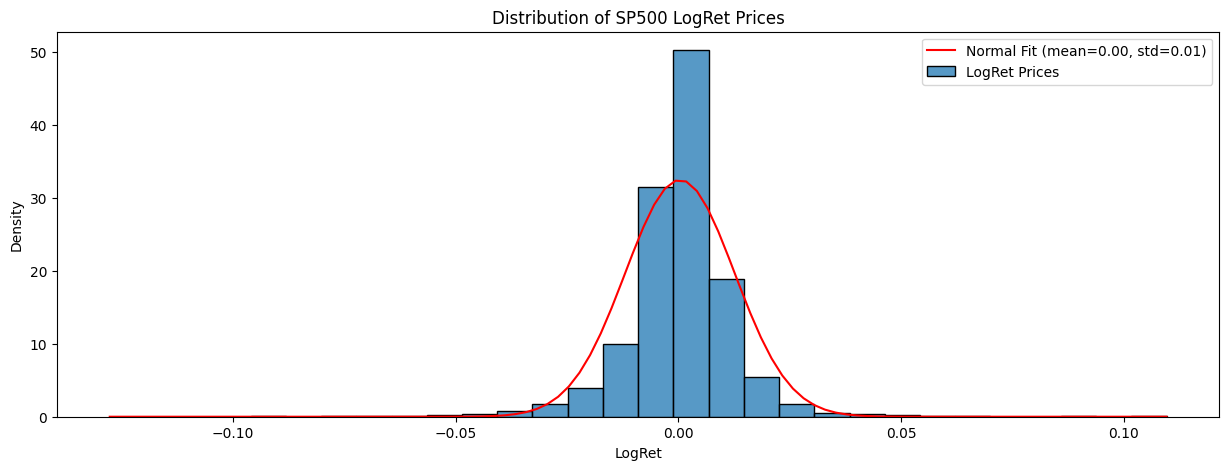

In [135]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt
df.dropna(inplace=True)
# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of SP500 LogRet Prices')
plt.legend()
plt.show()

## Stationarity analysis

In [136]:

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

stationarity_analysis(df=df, dataset_name="S&P500_raw")
stationarity_analysis(df=df, dataset_name="S&P500_log_returns", column_name='LogRet')


STATIONARITY ANALYSIS: S&P500_RAW

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: 2.214788
p-value: 0.998894
Critical Values:
	1%: -3.431658
	5%: -2.862118
	10%: -2.567078
ADF Result: NON-STATIONARY (Fail to reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 10.284780
p-value: 0.010000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: NON-STATIONARY (Reject null hypothesis)

--- COMBINED INTERPRETATION ---
CONCLUSION: Series is NON-STATIONARY

STATIONARITY ANALYSIS: S&P500_LOG_RETURNS

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -17.945452
p-value: 0.000000
Critical Values:
	1%: -3.431655
	5%: -2.862117
	10%: -2.567077
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 0.189312
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: STATIONARY (Fail to reject null hypothesis)

--- COMBIN

In [137]:
mean_lr = df['LogRet'].mean()
std_lr = df['LogRet'].std()
CLAMP_STD = 2

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['LogRet'] = np.where(df['LogRet'] > upper, upper,
                        np.where(df['LogRet'] < lower, lower, df['LogRet']))


In [138]:

df['LogRet'].mean()- df['LogRet'].std()

np.float64(-0.00931826083271606)

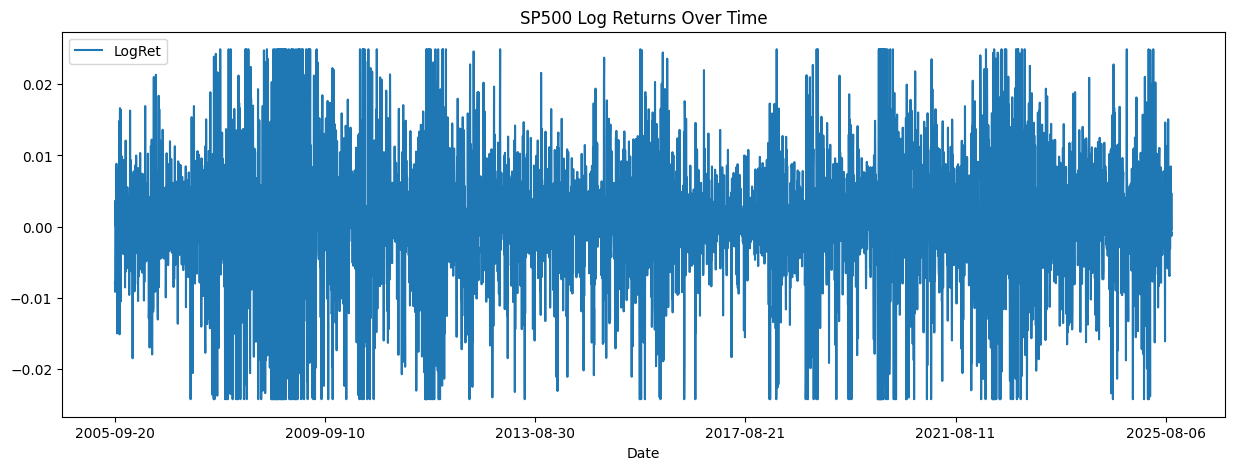

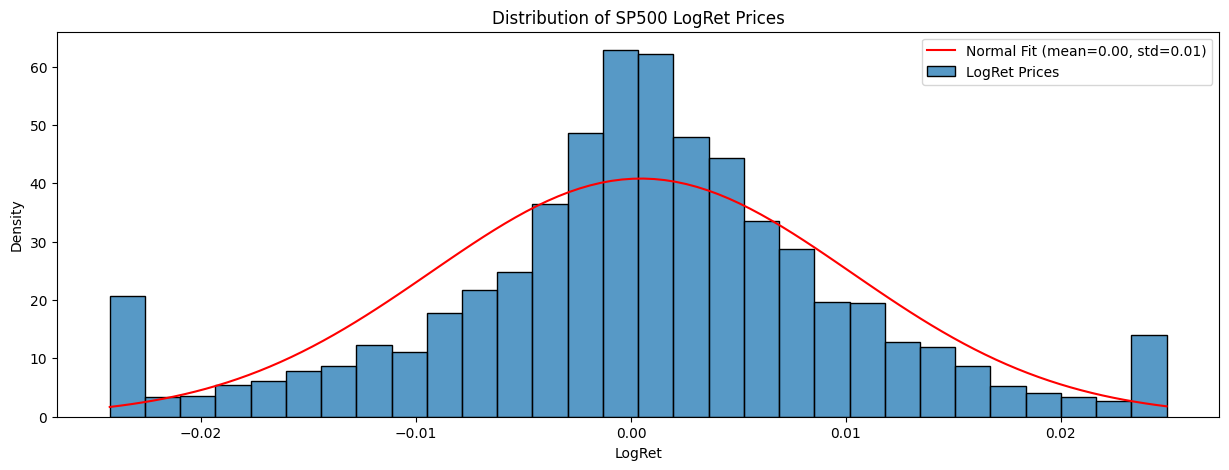

In [139]:
df.plot(x= 'Date', y='LogRet', title='SP500 Log Returns Over Time', figsize=(15,5))

# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of SP500 LogRet Prices')
plt.legend()
plt.show()

In [140]:
# create a collumn calles highlow_range which is the difference between the high and low prices
df['highlow_range'] = df['High'] - df['Low']


In [141]:
cordf = df.drop(columns=['Date']).corr()
# cordf = df.drop(columns=['Date']).corr()
cordf

,Close,High,Low,Open,Volume,LogRet,highlow_range
Close,1.000000,0.999914,0.999918,0.999834,0.114524,0.022796,0.513918
High,0.999914,1.000000,0.999864,0.999928,0.118703,0.014818,0.521229
Low,0.999918,0.999864,1.000000,0.999907,0.110566,0.016830,0.507062
Open,0.999834,0.999928,0.999907,1.000000,0.115361,0.008396,0.515222
Volume,0.114524,0.118703,0.110566,0.115361,1.000000,-0.053951,0.481497
LogRet,0.022796,0.014818,0.016830,0.008396,-0.053951,1.000000,-0.096326
highlow_range,0.513918,0.521229,0.507062,0.515222,0.481497,-0.096326,1.000000


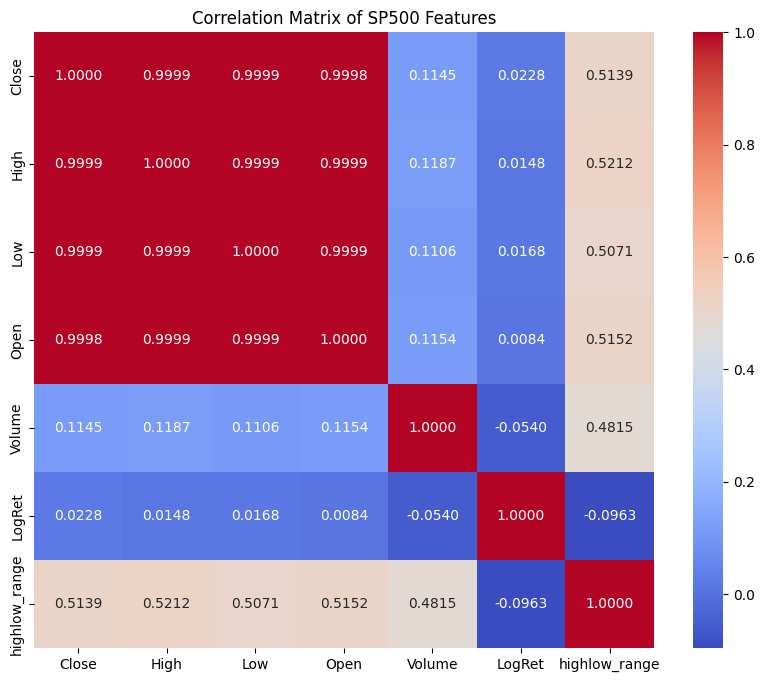

In [142]:
# correlation plot of all the features in the dataframe
plt.figure(figsize=(10, 8))
sns.heatmap(cordf, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of SP500 Features')
plt.show()

In [143]:
# Jupyter cell: Time-series forward-chaining CV + grid search for an Elman RNN (one-step ahead LogRet)
# Assumptions:
#  - `df` is a pandas DataFrame in the environment and contains at least:
#      ['Open', 'High', 'Low', 'Close', 'Volume', 'LogRet']
#  - We use features at time t to predict LogRet at t+1 (one-step ahead).
#  - 5 forward-chaining folds, StandardScaler fit only on training fold.
#  - Sequence length = 1 (t0 -> t1) as requested (Elman RNN still accepts seq_len dimension).
#  - This cell uses a small, practical param grid — extend as desired.

import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# -----------------------
# Repro / device
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
else:
    DEVICE = torch.device("cpu")

# -----------------------
# Prep features/targets (no lookahead)
# -----------------------
# Keep features at time t and target = LogRet at time t+1
cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'LogRet']
assert all(c in df.columns for c in cols), "df must contain columns: " + ", ".join(cols)

# Drop NA if present, keep original ordering
df_clean = df[cols].dropna().reset_index(drop=True)

# Features are rows 0 .. n-2 (t), targets are rows 1 .. n-1 (t+1)
X_all = df_clean.iloc[:-1].loc[:, ['Open','High','Low','Close','Volume','LogRet']].values.astype(float)
y_all = df_clean['LogRet'].iloc[1:].values.astype(float).reshape(-1, 1)  # shape (n_samples, 1)
n_samples = X_all.shape[0]
print(f"Prepared {n_samples} feature-target pairs (t -> t+1).")

# -----------------------
# Forward-chaining (dayforward) splitter
# -----------------------
def forward_chaining_splits(n_samples, n_splits=5):
    """
    Create expanding-window forward-chaining splits.
    For simplicity we create validation blocks of equal size (last block may be slightly larger).
    Returns list of (train_idx, val_idx) for each fold.
    """
    if n_splits < 1:
        raise ValueError("n_splits must be >= 1")
    # Determine validation block size as integer division of n_samples by (n_splits + 1)
    val_block = max(1, n_samples // (n_splits + 1))
    splits = []
    for i in range(1, n_splits + 1):
        train_end = i * val_block              # exclusive index for training (0..train_end-1)
        val_start = train_end
        val_end = val_start + val_block
        # For the last fold allow val_end to extend to n_samples
        if i == n_splits:
            val_end = n_samples
        train_idx = np.arange(0, train_end)
        val_idx = np.arange(val_start, val_end)
        if len(train_idx) == 0 or len(val_idx) == 0:
            # avoid empty splits; break if we can't create more valid folds
            break
        splits.append((train_idx, val_idx))
    return splits

n_splits = 5
splits = forward_chaining_splits(n_samples, n_splits=n_splits)
print(f"Created {len(splits)} forward-chaining folds. Fold sizes (train,val):")
for (tidx, vidx) in splits:
    print(f"  train={len(tidx)}, val={len(vidx)}")

# -----------------------
# PyTorch Dataset
# -----------------------
class TimeStepDataset(Dataset):
    """Dataset for single-step RNN input: each sample is (features at t, target at t+1)."""
    def __init__(self, X, y):
        # X: (N, features) ; y: (N, 1)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # return X as shape (seq_len=1, features) so DataLoader batches become (batch, seq_len, features)
        return self.X[idx:idx+1], self.y[idx]  # X slice keeps second dim consistent

# collate is default; DataLoader will stack first dimension -> (batch, 1, features)

# -----------------------
# Model: Elman RNN wrapper
# -----------------------
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, dropout=0.0):
        super().__init__()
        # batch_first=True => input shape (batch, seq_len, input_size)
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          nonlinearity='tanh',
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0)
        self.head = nn.Linear(hidden_size, 1)  # predict scalar LogRet
    def forward(self, x):
        # x: (batch, seq_len=1, input_size)
        out, h_n = self.rnn(x)               # out: (batch, seq_len, hidden_size)
        last = out[:, -1, :]                 # (batch, hidden_size)
        return self.head(last)               # (batch, 1)

# -----------------------
# Training / evaluation helpers
# -----------------------
def train_one_epoch(model, loader, opt, loss_fn):
    model.train()
    running_loss = 0.0
    n = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        opt.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        opt.step()
        bs = X_batch.shape[0]
        running_loss += loss.item() * bs
        n += bs
    return running_loss / n

def eval_loader(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    n = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            bs = X_batch.shape[0]
            running_loss += loss.item() * bs
            n += bs
    return running_loss / n

# -----------------------
# Grid search setup
# -----------------------
input_size = X_all.shape[1]  # features count

# Reasonable default param grid - small but meaningful
param_grid = {
    "hidden_size": [32, 64],
    "num_layers": [1],           # you asked Elman only for now
    "dropout": [0.0, 0.2],
    "lr": [1e-3, 1e-4],
    "batch_size": [64],
    "epochs": [30],              # number of epochs for each fold training
}

# Expand grid into list of dicts
from itertools import product
keys, values = zip(*param_grid.items())
grid_list = [dict(zip(keys, v)) for v in product(*values)]
print(f"Grid search combinations: {len(grid_list)}")

# -----------------------
# Cross-validation grid search (forward-chaining)
# -----------------------
best_config = None
best_score = float('inf')
results = []

for cfg in grid_list:
    fold_losses = []
    for fold_i, (train_idx, val_idx) in enumerate(splits):
        # Prepare X/y for this fold
        X_train = X_all[train_idx]
        y_train = y_all[train_idx]
        X_val = X_all[val_idx]
        y_val = y_all[val_idx]

        # Fit scaler only on training features (no leakage)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_val_s = scaler.transform(X_val)

        # Datasets and loaders
        train_ds = TimeStepDataset(X_train_s, y_train)
        val_ds = TimeStepDataset(X_val_s, y_val)
        train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=False, drop_last=False)
        val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False, drop_last=False)

        # Model / optimizer / loss (fresh init per fold)
        model = ElmanRNN(input_size=input_size,
                         hidden_size=cfg['hidden_size'],
                         num_layers=cfg['num_layers'],
                         dropout=cfg['dropout']).to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=cfg['lr'])
        loss_fn = nn.MSELoss()

        # Simple training loop with best-val tracking (no fancy LR sched)
        best_val = float('inf')
        # you can enable early stopping by uncommenting and adjusting patience
        patience = 5
        es_counter = 0

        for ep in range(cfg['epochs']):
            train_loss = train_one_epoch(model, train_loader, opt, loss_fn)
            val_loss = eval_loader(model, val_loader, loss_fn)
            # print(f"cfg {cfg} fold {fold_i} ep {ep} train_loss {train_loss:.6f} val_loss {val_loss:.6f}")
            if val_loss < best_val:
                best_val = val_loss
                es_counter = 0
            else:
                es_counter += 1
            if es_counter >= patience:
                break

        fold_losses.append(best_val)

    # average validation loss across folds (lower is better)
    avg_val = float(np.mean(fold_losses))
    results.append((cfg, avg_val))
    print(f"Config {cfg} -> avg val MSE: {avg_val:.6e}")

    if avg_val < best_score:
        best_score = avg_val
        best_config = cfg

print("\nGrid search completed.")
print(f"Best config: {best_config} with avg val MSE = {best_score:.6e}")

# -----------------------
# (Optional) Retrain best model on ALL available data (X_all, y_all) for final inference
# -----------------------
retrain_final = True
if best_config is not None and retrain_final:
    # Fit scaler on entire training set (which here is all X_all)
    final_scaler = StandardScaler().fit(X_all)
    X_all_s = final_scaler.transform(X_all)

    # DataLoader
    final_ds = TimeStepDataset(X_all_s, y_all)
    final_loader = DataLoader(final_ds, batch_size=best_config['batch_size'], shuffle=False)

    final_model = ElmanRNN(input_size=input_size,
                           hidden_size=best_config['hidden_size'],
                           num_layers=best_config['num_layers'],
                           dropout=best_config['dropout']).to(DEVICE)
    final_opt = torch.optim.Adam(final_model.parameters(), lr=best_config['lr'])
    loss_fn = nn.MSELoss()
    epochs = best_config.get('epochs', 30)

    for ep in range(epochs):
        train_loss = train_one_epoch(final_model, final_loader, final_opt, loss_fn)
        # simple progress print
        if (ep + 1) % 5 == 0 or ep == 0 or ep == epochs-1:
            print(f"Final training epoch {ep+1}/{epochs} - train loss: {train_loss:.6e}")

    # final_model and final_scaler can be used for inference: remember to transform new features with final_scaler
    print("Final model trained on all available data (X_t -> LogRet_{t+1}).")

# -----------------------
# Summary
# -----------------------
print("\nSummary of grid search results (top 5):")
results_sorted = sorted(results, key=lambda r: r[1])
for i, (cfg, score) in enumerate(results_sorted[:5]):
    print(f"{i+1:2d}. {cfg} -> avg val MSE {score:.6e}")

# The notebook cell ends here.
# Notes / potential extensions:
#  - If you later want to use multi-step or a longer input window, change TimeStepDataset to produce sequences of length >1.
#  - To compare Elman vs Jordan vs others, implement the relevant RNN variants and include them in the grid loop.
#  - If you need reproducible weight initialization across folds, set torch.manual_seed before each model init (we set seed globally above).
#  - Consider logging training curves, saving best fold models, and increasing the grid size if compute permits.


Prepared 5029 feature-target pairs (t -> t+1).
Created 5 forward-chaining folds. Fold sizes (train,val):
  train=838, val=838
  train=1676, val=838
  train=2514, val=838
  train=3352, val=838
  train=4190, val=839
Grid search combinations: 8
Config {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 64, 'epochs': 30} -> avg val MSE: 4.238749e-04
Config {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 64, 'epochs': 30} -> avg val MSE: 6.237448e-04
Config {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64, 'epochs': 30} -> avg val MSE: 5.888166e-04
Config {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 64, 'epochs': 30} -> avg val MSE: 7.393477e-04
Config {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 64, 'epochs': 30} -> avg val MSE: 4.092441e-03
Config {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'batch_size'